In [1161]:
import sys
import os.path
sys.path.append('/Users/abadarinath/Applications/anaconda/envs/UdacityNanoCar/lib/python3.5/site-packages')
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import pickle

CAMERA_CAL_DIRECTORY = './camera_cal/'


In [1162]:
def readImagesFromDir(dirPath,rgb=False):
    allDirfiles = [dirPath+f for f in listdir(dirPath) if isfile(join(dirPath, f))]
    result = []
    for i in range(len(allDirfiles)):
        if rgb:
            bgr_img = cv2.imread(os.path.abspath(allDirfiles[i]))
            b,g,r = cv2.split(bgr_img)       # get b,g,r
            result.append(cv2.merge([r,g,b]))
        else:
            result.append(cv2.imread(os.path.abspath(allDirfiles[i])))
    return result

In [1163]:
def displayImages(imgArray,isGray=False):
    plt.figure()
    for i in range(len(imgArray)):
        if isGray:
            plt.imshow(imgArray[i], cmap='gray')
            plt.show()
        else:
            plt.imshow(imgArray[i])
            plt.show()

In [1164]:
file = open(CAMERA_CAL_DIRECTORY+"dist_pickle.p",'rb')
distortion = pickle.load(file)
file.close()
def unDistortImage(img,debug=False):
    if debug:
        print("before image")
        displayImages([img])
        print("undistorted image")
        displayImages([dst])
    return cv2.undistort(img, distortion['mtx'], distortion['dist'], None, distortion['mtx'])

In [1219]:
def getPerspectiveTransform(img_size,reverse=False,debug=False,debugImg=None,cmap=None):
    srcPoints = np.array([[img_size[0]-270,img_size[1]-50],[img_size[0]-1020,img_size[1]-50],[img_size[0]-562,img_size[1]-249],[img_size[0]-718,img_size[1]-249]],np.float32)
    destPoints = np.array([[srcPoints[0][0],srcPoints[0][1]],[srcPoints[1][0],srcPoints[1][1]],[srcPoints[0][0],50],[srcPoints[1][0],50]],np.float32)
    if debug:
        plt.imshow(img,cmap=cmap)
        plt.plot(srcPoints[0][0],srcPoints[0][1],".")
        plt.plot(srcPoints[1][0],srcPoints[1][1],".")
        plt.plot(srcPoints[2][0],srcPoints[2][1],".")
        plt.plot(srcPoints[3][0],srcPoints[3][1],".")
        plt.show()
    if reverse:
        perspectiveTransform_M = cv2.getPerspectiveTransform(destPoints, srcPoints)
    else:
        perspectiveTransform_M = cv2.getPerspectiveTransform(srcPoints, destPoints)
    return (perspectiveTransform_M,srcPoints,destPoints)

def perspectiveTransform(img,debug=False,cmap=None):
    img_size = (img.shape[1], img.shape[0])
    (perspectiveMatrix,srcPoints,destPoints) = getPerspectiveTransform(img_size=img_size,debug=debug,debugImg=img,cmap=cmap)
    warped = cv2.warpPerspective(img, perspectiveMatrix, img_size)
    if debug:
        plt.imshow(warped,cmap=cmap)
        plt.plot(destPoints[0][0],destPoints[0][1],".")
        plt.plot(destPoints[1][0],destPoints[1][1],".")
        plt.plot(destPoints[2][0],destPoints[2][1],".")
        plt.plot(destPoints[3][0],destPoints[3][1],".")
        plt.show()
    return warped

In [1197]:
def cropHorizonInImage(img,debug=False):
    img_size = (img.shape[1], img.shape[0])
    newImg = img[img_size[1]/2:img_size[1], 0:img_size[0]] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    if debug:
        displayImages([newImg])
    return newImg

In [1198]:
def region_of_interest(img,debug=False,cmap=None,region=None):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    region_of_intrest = [[50,0],[1200,0],[500,350],[800,350]]
    if region != None:
        region_of_intrest = region
    img_size = [img.shape[1], img.shape[0]]
    srcPoints = [[img_size[0]-region_of_intrest[0][0],img_size[1]-region_of_intrest[0][1]],[img_size[0]-region_of_intrest[1][0],img_size[1]-region_of_intrest[1][1]],[img_size[0]-region_of_intrest[3][0],img_size[1]-region_of_intrest[3][1]],[img_size[0]-region_of_intrest[2][0],img_size[1]-region_of_intrest[2][1]]]
    
    if debug:
        print(srcPoints,type(np.array(srcPoints,dtype='int32')))
        plt.imshow(img,cmap=cmap)
        plt.plot(srcPoints[0][0],srcPoints[0][1])
        plt.plot(srcPoints[1][0],srcPoints[1][1])
        plt.plot(srcPoints[2][0],srcPoints[2][1])
        plt.plot(srcPoints[3][0],srcPoints[3][1])
        plt.show()
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [np.array(srcPoints)], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [1199]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread() or cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
    
    #Calculate the derivative in the x-direction (the 1, 0 at the end denotes x-direction):
    
    if orient == 'xy':
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) #x
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) #y
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        scaled_sobel = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) #x
        if orient == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) #y
        #Calculate the absolute value of the derivative:

        abs_sobel = np.absolute(sobel)
        #Convert the absolute value image to 8-bit:

        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        #Note: It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png. You could just as well choose a different standard range of values, like 0 to 1 etc.

        #Create a binary threshold to select pixels based on gradient strength:

        #thresh_min = 20
        #thresh_max = 100
        binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    return binary_output

def applySobel(img,debug=False,cmap=None):
    grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    if debug:
    # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(grad_binary,cmap=cmap)
        ax2.set_title('Thresholded Gradient', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return grad_binary

In [1200]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255),debug=False,ch='s'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    channel = S
    if ch == 'l':
        channel = L
    if ch == 'h':
        channel = H
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    if debug:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(binary_output, cmap='gray')
        ax2.set_title('Thresholded ', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return binary_output

In [1201]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [1202]:
def isolateLaneColorsAndReturnBinary(img,debug=False):
    boundaries = [([160, 170, 55], [255, 203, 130]),([200,200,200],[255,255,255])]

    # loop over the boundaries
    finalImg = None
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply
        # the mask
        mask = cv2.inRange(img, lower, upper)
        output = cv2.bitwise_and(img, img, mask = mask)
        if finalImg == None:
            finalImg = output
        else:
            finalImg = cv2.bitwise_or(finalImg, output)
        # show the images
        #cv2.imshow("images", np.hstack([image, output]))
        #cv2.waitKey(0)
    gray = cv2.cvtColor(finalImg, cv2.COLOR_BGR2GRAY)
    binary_output = np.zeros_like(gray)
    binary_output[(gray > 0) & (gray <= 255)] = 1
    
    if debug:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(finalImg)
        ax2.set_title('isolated', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(finalImg)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(binary_output, cmap='gray')
        ax2.set_title('binaryOutput', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    return binary_output

In [1203]:
from scipy import signal
from heapq import nlargest

def findLanePoints(histBinary,debug=False):
    peaks = []
    leftPeaks = []
    rightPeaks = []
    for i in range(len(histBinary)):
        tmp = np.array(signal.find_peaks_cwt(histBinary[i], np.arange(1,10)))
        nlargestIndexes = (nlargest(len(tmp), tmp, key=lambda j: histBinary[i][j]))
        peaks.append({"val":tmp, "nlargestIndexes":nlargestIndexes})
        data = np.array(peaks[i]["nlargestIndexes"])
        rightData = data[ np.where( np.logical_and(data > 640, data < 1200) ) ]
        rightPeaks.append({"val": rightData}) #right data already sorted
        leftData = data[ np.where( np.logical_and(data < 640, data > 200)) ]
        leftPeaks.append({"val": leftData}) #left data already sorted
    if debug:
        print("peaks",peaks)
        print("leftPeaks",leftPeaks)
        print("rightPeaks",rightPeaks)
    return (peaks,leftPeaks,rightPeaks)

In [1280]:
def freshCalculateLaneCurvature(binary_warped,histBinary,leftPeaks,rightPeaks,N_BOX,BOX_SIZE,debug=False):
    BOX_SIZE = BOX_SIZE * 2
    leftMaxPeaks = []
    rightMaxPeaks = []
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftPeaks[0]["val"][0]
    rightx_current = rightPeaks[0]["val"][0]
    # Set the width of the windows +/- margin
    margin = BOX_SIZE/2
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for i in range(N_BOX): #left and right peaks should be same len
        #print(i,len(leftMaxPeaks),len(histBinary),leftPeaks[i]["val"][0],len(histBinary))
        leftMaxPeaks.append(histBinary[i][leftPeaks[i]["val"][0]])
        rightMaxPeaks.append(histBinary[i][rightPeaks[i]["val"][0]])
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (i+1)*BOX_SIZE
        win_y_high = binary_warped.shape[0] - i*BOX_SIZE
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)
        
        if debug:
            # Draw the windows on the visualization image
            plt.imshow(out_img)
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
#             if i == N_BOX - 1:
#                 plt.show()
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            tmp = leftPeaks[i]["val"][0]
            if abs(tmp - leftx_current) < 50:
                leftx_current = tmp
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            tmp = rightPeaks[i]["val"][0]
            if abs(tmp - rightx_current) < 50:
                rightx_current = tmp

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    lstd = np.sum(np.array(leftMaxPeaks))
    rstd = np.sum(np.array(rightMaxPeaks))
    if debug:
        if lstd > rstd:
            print("More certain about left lane")
        else:
            print("More certain about right lane")
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1+100, binary_warped.shape[0]+100 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return (left_fit,right_fit,ploty,left_fitx,right_fitx)
        

def calculateLaneCurvatureAndAddonOriginalImage(binary_warped,histBinary,leftPeaks,rightPeaks,N_BOX,BOX_SIZE,debug=False,originalImg=False):
    left_fit,right_fit,ploty,left_fitx,right_fitx = freshCalculateLaneCurvature(binary_warped,histBinary,leftPeaks,rightPeaks,N_BOX,BOX_SIZE,debug)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((binary_warped, binary_warped, binary_warped))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    if debug:
        print(color_warp.shape)
        plt.imshow(color_warp)
        plt.show()
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size=(color_warp.shape[1], color_warp.shape[0])
    (perspectiveMatrix,srcPoints,destPoints) = getPerspectiveTransform(img_size=img_size,reverse=True,debug=False)
    newwarp = cv2.warpPerspective(color_warp, perspectiveMatrix, img_size)
    if debug:
        print("new warp",newwarp.shape)
        plt.imshow(newwarp)
        plt.show()
        print("original img",originalImg.shape)
        plt.imshow(originalImg)
        plt.show()

    s_img = newwarp
    l_img = np.zeros(originalImg.shape, np.uint8)
    x_offset=0
    y_offset=img_size[1]
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    if debug:
        plt.imshow(l_img)
        plt.show()

    # Combine the result with the original image
    result = cv2.addWeighted(originalImg, 1, l_img, 0.3, 0)
    if debug:
        plt.imshow(result)
        plt.show()
    
    return result

from scipy.misc import toimage
import PIL.Image
def blendImage(background,overlay,alpha=1.0,debug=False,cmap=None):
    blended = cv2.bitwise_or(background, overlay)
    if debug:
        print("blendImage")
        plt.imshow(background,cmap=cmap)
        plt.show()
        plt.imshow(overlay,cmap=cmap)
        plt.show()
        plt.imshow(blended,cmap=cmap)
        plt.show()
    return blended

In [1283]:
def pipeline(img,debug=False):
    orgImg = img
    unDistortedImg = unDistortImage(orgImg,False)
    croppedImg = cropHorizonInImage(unDistortedImg,debug=False)
    binaryImgs = []
    binaryImgs.append({'type':'hls_s','img':hls_select(croppedImg, thresh=(100, 255),debug=False),'final':None})
    binaryImgs.append({'type':'sobel','img':applySobel(croppedImg,debug=False,cmap='gray'),'final':None})
    binaryImgs.append({'type':'isolate','img':isolateLaneColorsAndReturnBinary(croppedImg,debug=False),'final':None})
    N_BOX = 10
    BOX_SIZE = 20
    MOVING_AVG_CONST = 10
    histogram = []
    finalMovingAvg = []
    finalBinaryWarpedImg = None
    for binaryImg in binaryImgs:
        regionOfIntrest = region_of_interest(binaryImg['img'],False,'gray')
        binaryImg['final'] = perspectiveTransform(binaryImg['img'],False,'gray')
        finalImg = binaryImg['final']
        if finalBinaryWarpedImg == None:
            finalBinaryWarpedImg = finalImg
        else:
            finalBinaryWarpedImg = blendImage(finalBinaryWarpedImg,finalImg,debug=False,cmap='gray')
        finalImgHeight = binaryImg['final'].shape[0]
        for i in range(0,N_BOX):
            tmpHeight = i * BOX_SIZE
            if finalImgHeight/2-tmpHeight < 0:
                print("SOMETHING WENT WRONG. Reduce the N_BOX or BOX_SIZE")
            tmpImg = finalImg[finalImgHeight/2-tmpHeight:finalImgHeight-tmpHeight,:]
            
            tmpHist = np.sum(tmpImg, axis=0)
            tmpMovingAvg = moving_average(tmpHist,n=MOVING_AVG_CONST)
            tmpMovingAvg = np.insert(tmpMovingAvg,0,np.zeros(MOVING_AVG_CONST-1))

            if i >= len(histogram):
                histogram.append(tmpHist)
                finalMovingAvg.append(tmpMovingAvg)
            else:
                histogram[i] = np.add(histogram[i],tmpHist)
                finalMovingAvg[i] = np.add(finalMovingAvg[i],tmpMovingAvg)

#             if debug:
#                 plt.imshow(tmpImg,cmap='gray')
#                 tmp2 = moving_average(tmpHist,n=MOVING_AVG_CONST)
#                 tmp2 = np.insert(tmp2,0,np.zeros(MOVING_AVG_CONST-1))
#                 #plt.plot(tmpHist)
#                 plt.plot(tmp2)
#                 plt.show()
    peaks,leftPeaks,rightPeaks = findLanePoints(finalMovingAvg,False)
    result = calculateLaneCurvatureAndAddonOriginalImage(binary_warped=finalBinaryWarpedImg,histBinary=finalMovingAvg,leftPeaks=leftPeaks,rightPeaks=rightPeaks,N_BOX=N_BOX,BOX_SIZE=BOX_SIZE,debug=False,originalImg=orgImg)

    if debug:
        plt.imshow(croppedImg)
        for tmp in histogram:
            plt.plot(tmp)
        for tmp in finalMovingAvg:
            plt.plot(tmp)
        plt.show()  
    return result

/Users/abadarinath/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/abadarinath/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/abadarinath/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/abadarinath/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


More certain about left lane
Final result


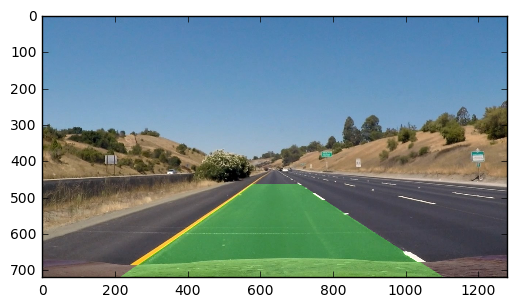

In [1284]:
testImgs = readImagesFromDir('./test_images/',True)

for i in range(1):#len(testImgs)):
    img = testImgs[i]
    result = pipeline(img, False)
    print("Final result")
    plt.imshow(result)
    plt.show()